In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.metrics import balanced_accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report, cohen_kappa_score
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Flatten, Dropout


In [2]:
epochs = 20
learning_rate = 3.9e-5
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
folder_path = './../../datasets/dataset1'
num_classes = 5
validation_split = 0.2
test_split = 0.2  # Proportion of the data to use for testing

# Load image file paths and their corresponding labels
image_paths = []
labels = []

class_names = sorted(os.listdir(folder_path))
class_indices = {name: i for i, name in enumerate(class_names)}

for class_name in class_names:
    class_path = os.path.join(folder_path, class_name)
    for file_name in os.listdir(class_path):
        file_path = os.path.join(class_path, file_name)
        image_paths.append(file_path)
        labels.append(class_indices[class_name])

image_paths = np.array(image_paths)
labels = np.array(labels)

# Split the data into training, validation, and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=test_split, stratify=labels, random_state=42)
train_paths, val_paths, train_labels, val_labels = train_test_split(train_paths, train_labels, test_size=validation_split, stratify=train_labels, random_state=42)

# Function to load and preprocess the images
def preprocess_image(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0  # Normalize to [0,1]
    label = tf.one_hot(label, num_classes)
    return image, label

# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=len(train_paths)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_dataset = val_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_dataset = test_dataset.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)



In [3]:
def balanced_accuracy(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    return tf.py_function(
        func=lambda y_true, y_pred: balanced_accuracy_score(
            y_true.numpy(), y_pred.numpy()),
        inp=[y_true, y_pred],
        Tout=tf.float64)


def fscore(y_true, y_pred):
    y_true = tf.cast(tf.argmax(y_true, axis=1), tf.int32)
    y_pred = tf.cast(tf.argmax(y_pred, axis=1), tf.int32)

    def compute_fscore(y_true, y_pred):
        _, _, fscore, _ = precision_recall_fscore_support(
            y_true, y_pred, average='macro', zero_division=0)
        return fscore

    return tf.py_function(func=compute_fscore, inp=[y_true, y_pred], Tout=tf.float64)

# Custom Kappa Metric
def kappa_score(y_true, y_pred):
    y_true = tf.argmax(y_true, axis=1)
    y_pred = tf.argmax(y_pred, axis=1)
    kappa_score = tf.py_function(func=cohen_kappa_score, inp=[y_true, y_pred], Tout=tf.float32)
    return kappa_score

In [4]:

metrics = [
    'accuracy',
    tf.keras.metrics.AUC(),
    balanced_accuracy,
    fscore,
    kappa_score,
    tf.keras.metrics.Precision(),
    tf.keras.metrics.Recall()
]

In [5]:
import warnings
warnings.filterwarnings('ignore', message="A single label was found in y_true and y_pred.")
warnings.filterwarnings('ignore', message="y_pred contains classes not in y_true") 
warnings.filterwarnings('ignore', message="A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.") 


def accuracyGraph(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    print ('train_accuracy-> ', train_accuracy)
    print ('val_accuracy-> ', val_accuracy)
    print ('train_loss-> ', train_loss)
    print ('val_loss-> ', val_loss)

    epochs_no = range(len(train_accuracy) + 1)


    # Plot accuracy
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 1)
    plt.plot(epochs_no, [0] + train_accuracy, 'b', label='Train Accuracy')
    plt.plot(epochs_no, [0] + val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_no, [0] + train_loss, 'b', label='Train Loss')
    plt.plot(epochs_no, [0] + val_loss, 'r', label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure(figsize=(14, 7))
    plt.subplot(2, 2, 3)
    plt.plot(epochs_no, [0] + val_accuracy, 'b')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    # Plot loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs_no, [0] + val_loss, 'r')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()
    
def show_confusion_matrix(model):
    y_true = np.concatenate([y for x, y in test_dataset], axis=0)
    if y_true.ndim > 1 and y_true.shape[1] > 1:
        y_true = np.argmax(y_true, axis=1)

    y_pred = model.predict(test_dataset)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(classification_report(y_true, y_pred_classes, target_names=[str(i) for i in range(num_classes)], zero_division=0))

    conf_matrix = confusion_matrix(y_true, y_pred_classes)
    print(conf_matrix)

    # Plot the confusion matrix
    def plot_confusion_matrix(cm, class_names):
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.title('Confusion Matrix')
        plt.show()

    plot_confusion_matrix(conf_matrix, [str(i) for i in range(num_classes)])

    

In [6]:
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
# Add custom top layers
for layer in base_model.layers:
    layer.trainable = False
    
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(5, activation='softmax')(x)  
model = Model(inputs=base_model.input, outputs=output)

171446536/171446536 [==============================] - 5s 0us/step


In [7]:
# Compile the model with the custom loss function
model.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())


# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

train_accuracy->  [0.7304715514183044, 0.7346529960632324, 0.7347864508628845, 0.7346975207328796, 0.7347864508628845, 0.7347864508628845, 0.7347864508628845, 0.7347864508628845, 0.7348309755325317, 0.7347864508628845, 0.7347864508628845, 0.7348309755325317, 0.7348309755325317, 0.7348309755325317, 0.7347864508628845, 0.7347864508628845, 0.7348309755325317, 0.7348309755325317, 0.7348309755325317, 0.7347864508628845]
val_accuracy->  [0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342, 0.7348754405975342]
train_loss->  [0.9355096817016602, 0.9143019318580627, 0.9141563177108765, 0.9107552170753479, 0.9040178656578064, 0.9048343300819397, 0.902885913848877, 0.90479576

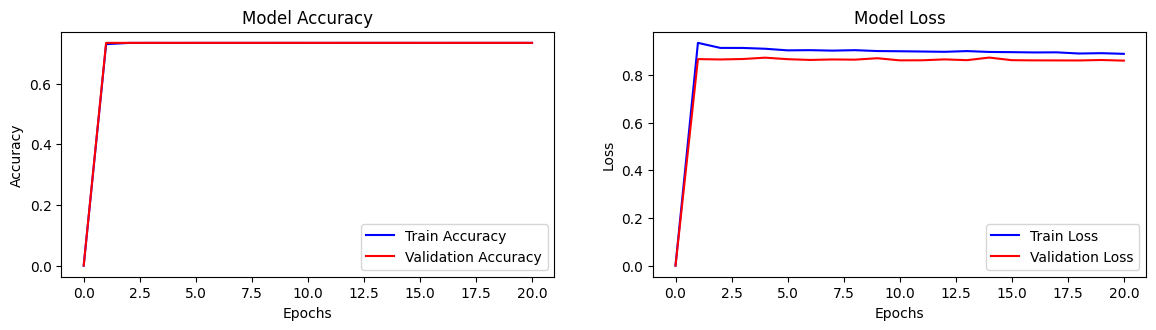

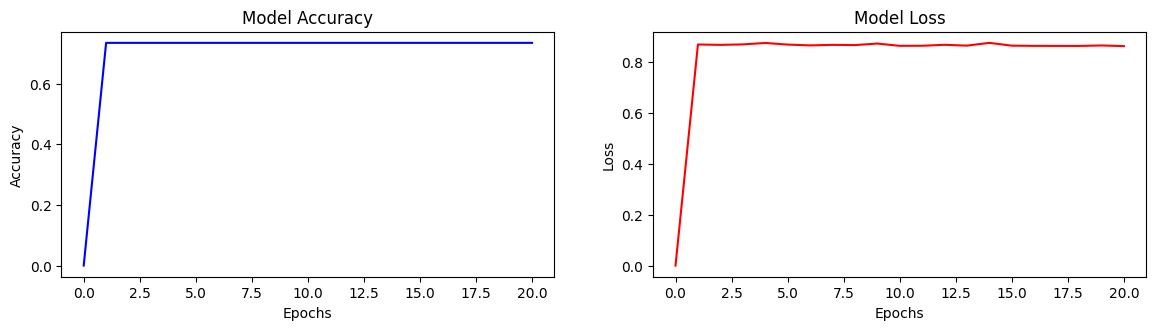

In [8]:
accuracyGraph(history)

220/220 [==============================] - 23s 96ms/step
              precision    recall  f1-score   support

           0       0.73      1.00      0.85      5162
           1       0.00      0.00      0.00       489
           2       0.00      0.00      0.00      1058
           3       0.00      0.00      0.00       175
           4       0.00      0.00      0.00       142

    accuracy                           0.73      7026
   macro avg       0.15      0.20      0.17      7026
weighted avg       0.54      0.73      0.62      7026

[[5162    0    0    0    0]
 [ 489    0    0    0    0]
 [1058    0    0    0    0]
 [ 175    0    0    0    0]
 [ 142    0    0    0    0]]


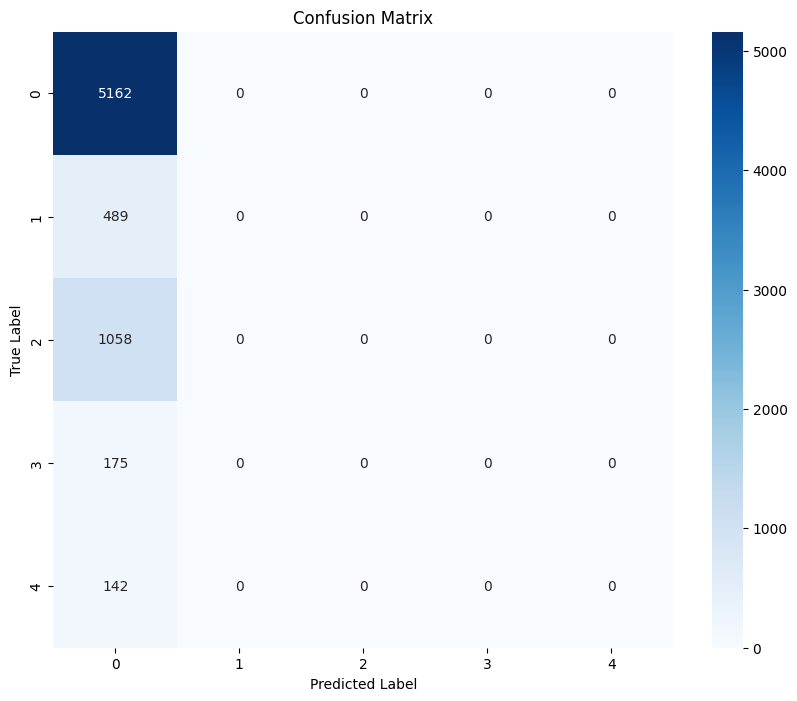

In [9]:
show_confusion_matrix(model)

In [10]:
_metrices = model.evaluate(test_dataset)
print("Test Metrices", _metrices)

220/220 [==============================] - 22s 102ms/step - loss: 0.8644 - accuracy: 0.7347 - auc: 0.8951 - balanced_accuracy: 0.2650 - fscore: 0.2252 - kappa_score: 0.0000e+00 - precision: 0.7347 - recall: 0.7347
Test Metrices [0.8644266128540039, 0.7346996665000916, 0.8950933814048767, 0.2650000751018524, 0.22515204548835754, 0.0, 0.7346996665000916, 0.7346996665000916]


In [19]:


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.1)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
# x = tf.keras.layers.Dense(256, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.1)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Fine-tuning: Unfreeze some layers of the base model
for layer in base_model.layers[:22]:   
    layer.trainable = False
for layer in base_model.layers[22:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
# model.compile(optimizer=Adam(lr=0.00001), loss=loss_fn, metrics=['accuracy'])
model.compile(optimizer=Adam(lr=learning_rate), loss="categorical_crossentropy", metrics=metrics)
print(model.summary())

# Continue training (fine-tuning)
# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    batch_size=BATCH_SIZE
)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

c:\Users\Computing\anaconda3\envs\AML\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)       

train_accuracy->  [0.9818950295448303, 0.9913256168365479, 0.9950622916221619, 0.9919928908348083, 0.9945729374885559, 0.9932384490966797, 0.9939057230949402, 0.9928380846977234, 0.993861198425293, 0.9948398470878601, 0.9957295656204224, 0.9930160045623779, 0.9949733018875122, 0.9952402114868164, 0.9931939244270325, 0.9949733018875122, 0.9950177669525146, 0.9959074854850769, 0.9949733018875122, 0.9948843121528625]
val_accuracy->  [0.7313167452812195, 0.7330960631370544, 0.7172597646713257, 0.7346975207328796, 0.7348754405975342, 0.7291814684867859, 0.6918149590492249, 0.7350533604621887, 0.7357650995254517, 0.7348754405975342, 0.7290035486221313, 0.735231339931488, 0.7104982137680054, 0.7348754405975342, 0.7231316566467285, 0.7348754405975342, 0.7338078022003174, 0.713701069355011, 0.7346975207328796, 0.7298932671546936]
train_loss->  [0.05365848168730736, 0.025936635211110115, 0.014793355017900467, 0.023032288998365402, 0.01723591983318329, 0.021162182092666626, 0.017157886177301407, 

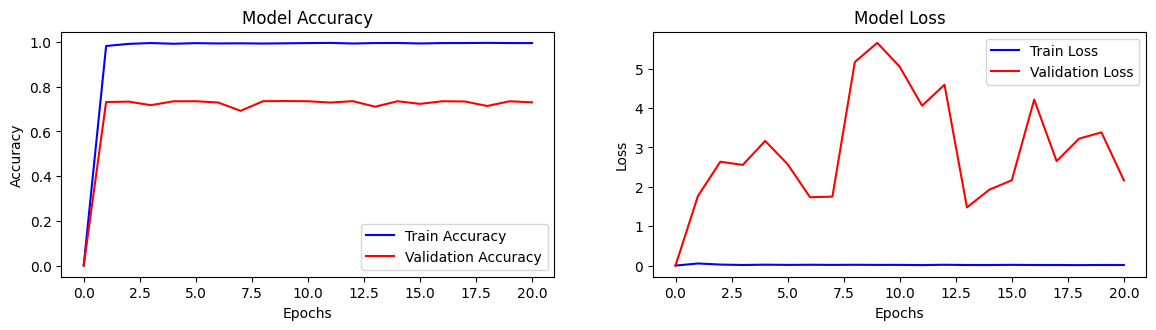

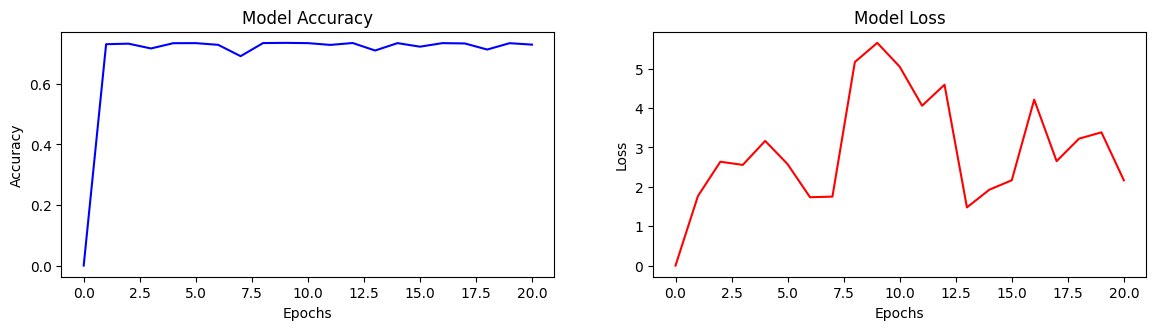

In [20]:
accuracyGraph(history)

220/220 [==============================] - 22s 94ms/step
              precision    recall  f1-score   support

           0       0.74      0.98      0.84      5162
           1       0.00      0.00      0.00       489
           2       0.11      0.01      0.02      1058
           3       0.00      0.00      0.00       175
           4       0.00      0.00      0.00       142

    accuracy                           0.73      7026
   macro avg       0.17      0.20      0.17      7026
weighted avg       0.56      0.73      0.62      7026

[[5081    0   81    0    0]
 [ 474    0   15    0    0]
 [1045    0   13    0    0]
 [ 169    0    6    0    0]
 [ 140    0    2    0    0]]


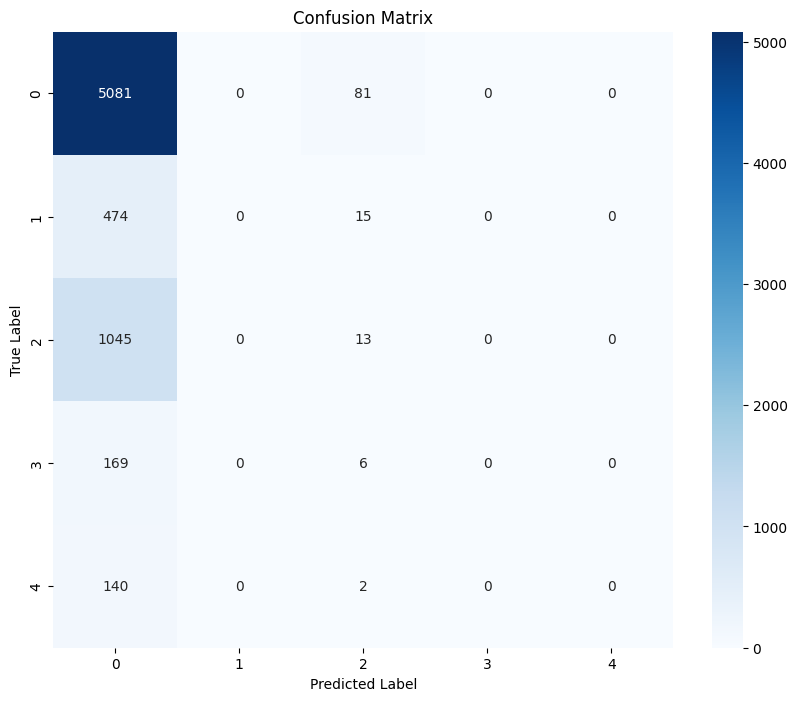

In [17]:
show_confusion_matrix(model)

In [21]:
_metrices = model.evaluate(test_dataset)
# _metrices = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

print("Test Metrices", _metrices)

220/220 [==============================] - 22s 100ms/step - loss: 2.1763 - accuracy: 0.7294 - auc: 0.8462 - balanced_accuracy: 0.2666 - fscore: 0.2263 - kappa_score: 0.0050 - precision: 0.7300 - recall: 0.7287
Test Metrices [2.176337242126465, 0.729433536529541, 0.8462336659431458, 0.2666425406932831, 0.22633570432662964, 0.005041580181568861, 0.7299686074256897, 0.7287219166755676]
